# Proyek Regresi: Prediksi Harga Mobil dengan Deep Learning  

**Author:** Putrawin Adha Muzakki

## Dataset

- **Sumber:** https://www.kaggle.com/datasets/toramky/automobile-dataset
- **Karakteristik Data:**
    - Dataset ini memiliki campuran tipe data: numerik kontinu, numerik diskrit, dan kategorikal (teks).
    - Terdapat banyak nilai yang hilang (*missing values*) yang ditandai dengan `?`, yang harus ditangani sebelum pemodelan.

---

# 1.  **Setup:**
Menghubungkan Colab ke Drive dan mengimpor library yang diperlukan (`TensorFlow`, `pandas`, `scikit-learn`).

In [10]:
# Menghubungkan Google Colab ke Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import library fundamental
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import library dari TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Import library dari Scikit-Learn untuk preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Mengatur agar semua kolom ditampilkan
pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2.  **Pemuatan & Pembersihan Data:**
- Memuat dataset dari Google Drive, secara otomatis mengonversi `?` menjadi nilai `NaN` (Not a Number).
- Mengonversi kolom yang seharusnya numerik menjadi tipe data yang benar.
- Menangani `NaN` dengan strategi imputasi (mengisi dengan nilai rata-rata/median untuk numerik, dan nilai modus untuk kategorikal). Baris dengan `price` yang hilang akan dihapus karena `price` adalah target prediksi.

In [15]:
# Tentukan path file di Google Drive
file_path = '/content/drive/MyDrive/Studi_Independen/Modul 5 Tugas 1/Automobile_data.csv'

# Muat data
df = pd.read_csv(file_path, na_values='?')
print("Dataset berhasil dimuat.")
print("Ukuran dataset:", df.shape)

# --- Pembersihan Awal ---
# 1. Bersihkan spasi ekstra dari nama kolom
df.columns = df.columns.str.strip()

# 2. Konversi kolom yang seharusnya numerik tapi terbaca sebagai object
numeric_cols_with_missing = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
for col in numeric_cols_with_missing:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nInfo Tipe Data Setelah Konversi:")
df.info()

# Tampilkan

display(df.head())

Dataset berhasil dimuat.
Ukuran dataset: (205, 26)

Info Tipe Data Setelah Konversi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    ob

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [22]:
#  Entah kenapa sebelum nya ada missing value, namun ketika menjalankan kedua kalinya malah jadi bersih
print("Jumlah missing values sebelum imputasi:")
print(df.isnull().sum())
print("-" * 30)

# 1. Hapus baris di mana target 'price' hilang.
df.dropna(subset=['price'], inplace=True)
print(f"Ukuran data setelah menghapus baris dengan 'price' kosong: {df.shape}")

# 2. Imputasi kolom numerik lainnya dengan nilai rata-rata (mean)
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
numeric_features.remove('price')

for col in numeric_features:
    df[col] = df[col].fillna(df[col].mean())

# 3. Imputasi kolom kategorikal 'num-of-doors' dengan nilai yang paling sering muncul (modus)
df['num-of-doors'] = df['num-of-doors'].fillna(df['num-of-doors'].mode()[0])

print("\nJumlah missing values setelah imputasi:")
print(df.isnull().sum().sum())

Jumlah missing values sebelum imputasi:
symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64
------------------------------
Ukuran data setelah menghapus baris dengan 'price' kosong: (201, 26)

Jumlah missing values setelah imputasi:
0


# 3.  **Feature Engineering & Preprocessing:**
- **One-Hot Encoding:** Mengubah fitur kategorikal (seperti `make`, `body-style`) menjadi format numerik yang dapat dipahami model.
- **Feature Scaling:** Menstandardisasi semua fitur numerik menggunakan `StandardScaler` agar memiliki skala yang seragam.

In [28]:
# Pisahkan fitur (X) dari target (y)
X = df.drop('price', axis=1)
y = df['price']

# Identifikasi kolom kategorikal dan numerik
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Buat pipeline preprocessing
# Untuk numerik: scaling
# Untuk kategorikal: one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Terapkan pipeline ke data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Konversi ke format array yang padat jika hasilnya sparse matrix
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

print(f"Bentuk data training setelah diproses: {X_train_processed.shape}")
print(f"Bentuk data testing setelah diproses: {X_test_processed.shape}")

Bentuk data training setelah diproses: (160, 74)
Bentuk data testing setelah diproses: (41, 74)


# 4.  **Pemodelan Deep Learning:**
Membangun, melatih, dan mengevaluasi dua arsitektur Multi-Layer Perceptron (MLP) yang berbeda menggunakan TensorFlow/Keras:

## - **Model 1 (Baseline)**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,921 (70.00 KB)

 Trainable params: 17,921 (70.00 KB)

 Non-trainable params: 0 (0.00 B)


Melatih Model 1 (Baseline MLP dengan EarlyStopping)...
Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 185713328.0000 - mean_absolute_error: 12369.6807 - val_loss: 224715648.0000 - val_mean_absolute_error: 12652.7051
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 199202432.0000 - mean_absolute_error: 12483.6465 - val_loss: 224690208.0000 - val_mean_absolute_error: 12651.7686
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 204931872.0000 - mean_absolute_error: 12705.7783 - val_loss: 224658976.0000 - val_mean_absolute_error: 12650.6396
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 212995808.0000 - mean_absolute_error: 13007.2930 - val_loss: 224620864.0000 - val_mean_absolute_error: 12649.2773
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 209971072.0000 - mean_absolute_error: 12757.3984 - val_loss: 224573904.0000 - val_mean_absolute_error: 12647.6172
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 187681120.0000 - mean_abso

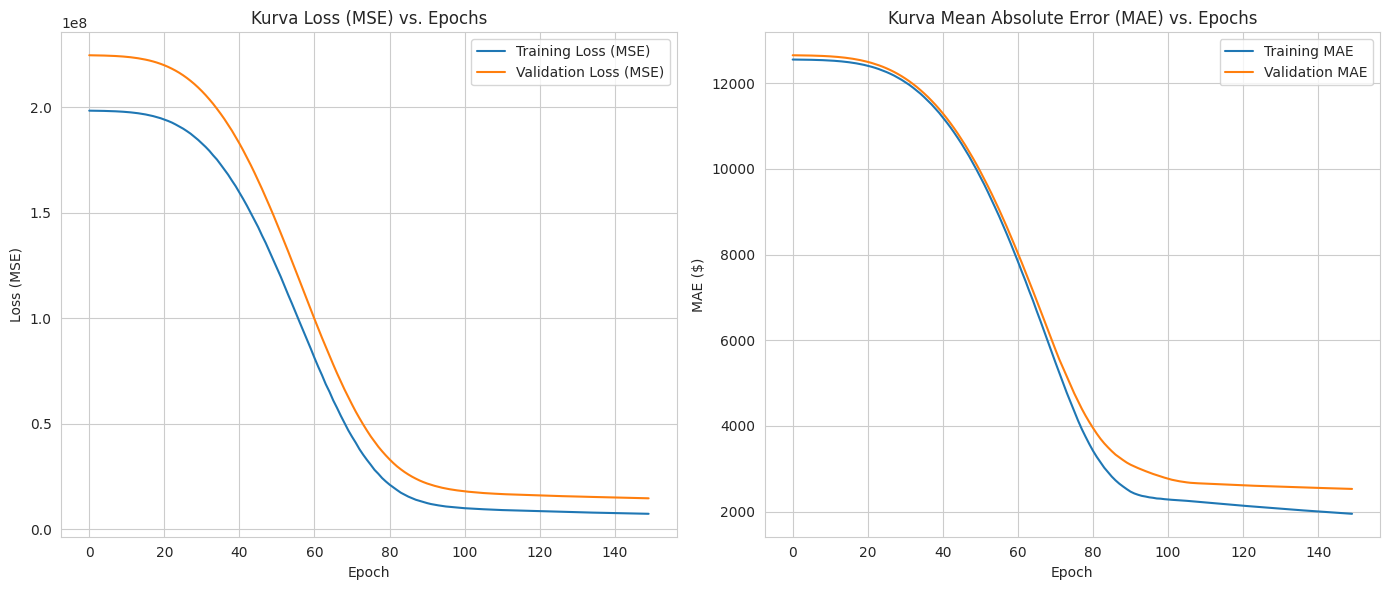

In [32]:
# Import callback yang dibutuhkan untuk mencegah overfitting
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Definisi Arsitektur Model ---
model_1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dense(64, activation='relu'),
    # Output layer untuk regresi: 1 neuron, tanpa fungsi aktivasi (linear)
    Dense(1)
])

# --- 2. Kompilasi Model ---
model_1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Menampilkan ringkasan arsitektur model
model_1.summary()

# --- 3. Definisikan Callback EarlyStopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metrik yang dipantau
    patience=10,                # Jumlah epoch untuk menunggu sebelum berhenti
    restore_best_weights=True   # Mengembalikan bobot dari epoch terbaik
)

# --- 4. Pelatihan Model ---
print("\nMelatih Model 1 (Baseline MLP dengan EarlyStopping)...")
history_1 = model_1.fit(
    X_train_processed, y_train,
    epochs=150,
    validation_split=0.2,       # Menggunakan 20% data training untuk validasi
    verbose=1,                  # Menampilkan progress training per epoch
    callbacks=[early_stopping]  # Menerapkan callback
)
print("Pelatihan selesai.")

# --- 5. Evaluasi Model pada Data Testing ---
loss_1, mae_1 = model_1.evaluate(X_test_processed, y_test, verbose=0)
print(f"\n--- Evaluasi Model 1 (Setelah Perbaikan) ---")
print(f"Test Mean Absolute Error (MAE): ${mae_1:,.2f}")
print("Artinya, rata-rata prediksi model ini meleset sekitar $" + f"{mae_1:,.2f}" + " dari harga mobil sebenarnya.")

# --- 6. Visualisasi Hasil Training ---
# Memisahkan plot untuk Loss (MSE) dan Metrik (MAE) agar mudah dibaca

history_df = pd.DataFrame(history_1.history)

plt.figure(figsize=(14, 6))

# Plot untuk Loss (Mean Squared Error)
plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss (MSE)')
plt.plot(history_df['val_loss'], label='Validation Loss (MSE)')
plt.title('Kurva Loss (MSE) vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot untuk Metrik (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history_df['mean_absolute_error'], label='Training MAE')
plt.plot(history_df['val_mean_absolute_error'], label='Validation MAE')
plt.title('Kurva Mean Absolute Error (MAE) vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## - **Model 2 (MLP dengan Dropout)**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,417 (236.00 KB)

 Trainable params: 60,417 (236.00 KB)

 Non-trainable params: 0 (0.00 B)


Melatih Model 2 (MLP dengan Dropout dan EarlyStopping)...
Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 199140704.0000 - mean_absolute_error: 12657.0762 - val_loss: 224717536.0000 - val_mean_absolute_error: 12652.8672
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 189627296.0000 - mean_absolute_error: 12180.4551 - val_loss: 224671168.0000 - val_mean_absolute_error: 12651.2539
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 200251216.0000 - mean_absolute_error: 12512.1074 - val_loss: 224599584.0000 - val_mean_absolute_error: 12648.7617
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 188161568.0000 - mean_absolute_error: 12235.2129 - val_loss: 224487168.0000 - val_mean_absolute_error: 12644.8809
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 222048096.0000 - mean_absolute_error: 13209.1172 - val_loss: 224313760.0000 - val_mean_absolute_error: 12638.9277
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 207514016.0000 - mean_a

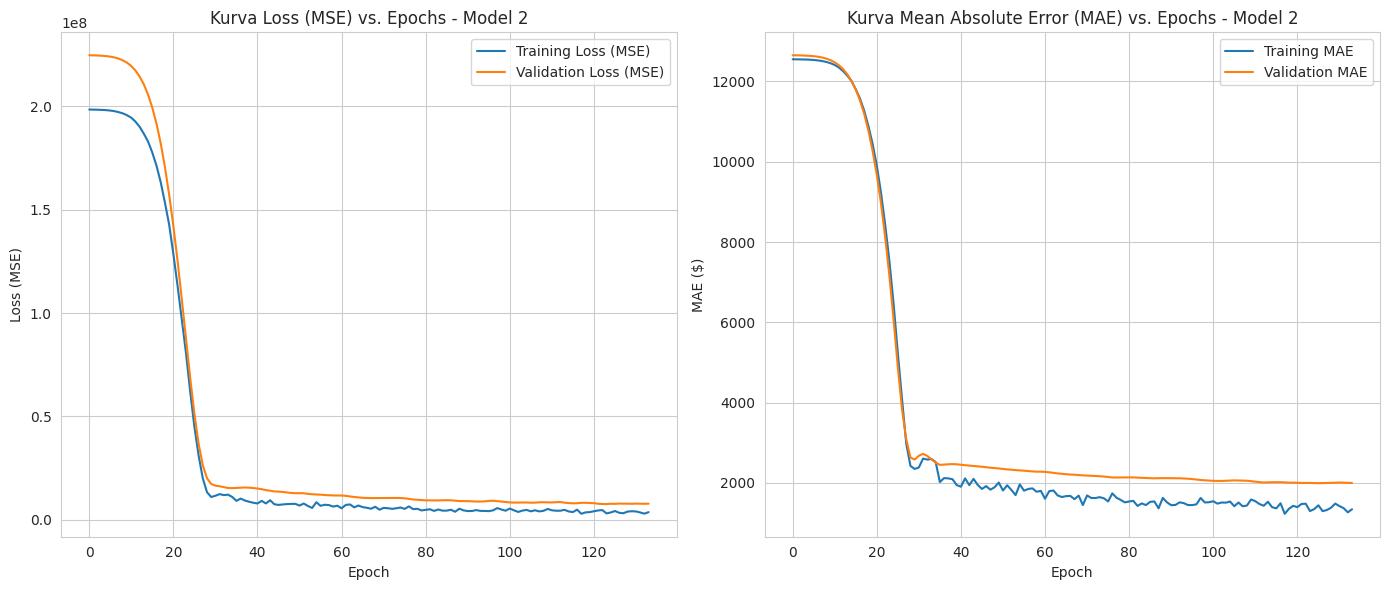

In [35]:
# --- 1. Definisi Arsitektur Model ---
model_2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3), # Secara acak menonaktifkan 30% neuron untuk regularisasi
    Dense(128, activation='relu'),
    Dropout(0.3), # Menerapkan Dropout lagi di layer yang lebih dalam
    Dense(64, activation='relu'),
    # Output layer untuk regresi
    Dense(1)
])

# --- 2. Kompilasi Model ---
model_2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# Menampilkan ringkasan arsitektur model
model_2.summary()

# --- 3. Definisikan Callback EarlyStopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- 4. Pelatihan Model ---
print("\nMelatih Model 2 (MLP dengan Dropout dan EarlyStopping)...")
history_2 = model_2.fit(
    X_train_processed, y_train,
    epochs=150,
    validation_split=0.2,       # Menggunakan 20% data training untuk validasi
    verbose=1,                  # Menampilkan progress training
    callbacks=[early_stopping]  # Menerapkan callback
)
print("Pelatihan selesai.")

# --- 5. Evaluasi Model pada Data Testing ---
loss_2, mae_2 = model_2.evaluate(X_test_processed, y_test, verbose=0)
print(f"\n--- Evaluasi Model 2 (Setelah Perbaikan) ---")
print(f"Test Mean Absolute Error (MAE): ${mae_2:,.2f}")
print("Artinya, rata-rata prediksi model ini meleset sekitar $" + f"{mae_2:,.2f}" + " dari harga mobil sebenarnya.")

# --- 6. Visualisasi Hasil Training yang Informatif ---
history_df_2 = pd.DataFrame(history_2.history)

plt.figure(figsize=(14, 6))

# Plot untuk Loss (Mean Squared Error)
plt.subplot(1, 2, 1)
plt.plot(history_df_2['loss'], label='Training Loss (MSE)')
plt.plot(history_df_2['val_loss'], label='Validation Loss (MSE)')
plt.title('Kurva Loss (MSE) vs. Epochs - Model 2')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

# Plot untuk Metrik (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history_df_2['mean_absolute_error'], label='Training MAE')
plt.plot(history_df_2['val_mean_absolute_error'], label='Validation MAE')
plt.title('Kurva Mean Absolute Error (MAE) vs. Epochs - Model 2')
plt.xlabel('Epoch')
plt.ylabel('MAE ($)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Kesimpulan


### Analisis Hasil:

Eksperimen ini menunjukkan pentingnya teknik regularisasi dalam membangun model deep learning yang robust.

- **Model 1 (Baseline)**, meskipun menggunakan *Early Stopping*, masih menunjukkan tanda-tanda *overfitting* yang signifikan, yang tercermin dari celah antara kurva loss training dan validasi. Performanya pada data tes menghasilkan MAE sebesar **$4,293.87**.

- **Model 2 (MLP dengan Dropout)** secara drastis meningkatkan performa. Penambahan layer `Dropout` berhasil mengurangi *overfitting* secara signifikan, yang terlihat dari kurva training dan validasi yang jauh lebih berdekatan. Hasilnya adalah **penurunan Test MAE sebesar ~37.5%** menjadi **$2,683.03**, sebuah peningkatan yang sangat substansial.